In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"


# Data


In [3]:
# custom_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])
# train_dataset = datasets.MNIST(root='./../datasets', train=True, download=True, transform=custom_transform)
# test_dataset = datasets.MNIST(root='./../datasets', train=False, download=True, transform=custom_transform)

# Model


In [4]:
def mnist_iid(dataset, num_users):
    """
    Sample I.I.D. client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items,
                                             replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users


def mnist_noniid(dataset, num_users):
    """
    Sample non-I.I.D client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return:
    """
    # 60,000 training imgs -->  200 imgs/shard X 300 shards
    num_shards, num_imgs = 200, 300
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    labels = dataset.train_labels.numpy()

    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    idxs = idxs_labels[0, :]

    # divide and assign 2 shards/client
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, 2, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_users[i] = np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
    return dict_users


def mnist_noniid_unequal(dataset, num_users):
    """
    Sample non-I.I.D client data from MNIST dataset s.t clients
    have unequal amount of data
    :param dataset:
    :param num_users:
    :returns a dict of clients with each clients assigned certain
    number of training imgs
    """
    # 60,000 training imgs --> 50 imgs/shard X 1200 shards
    num_shards, num_imgs = 1200, 50
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    labels = dataset.train_labels.numpy()

    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    idxs = idxs_labels[0, :]

    # Minimum and maximum shards assigned per client:
    min_shard = 1
    max_shard = 30

    # Divide the shards into random chunks for every client
    # s.t the sum of these chunks = num_shards
    random_shard_size = np.random.randint(min_shard, max_shard+1,
                                          size=num_users)
    random_shard_size = np.around(random_shard_size /
                                  sum(random_shard_size) * num_shards)
    random_shard_size = random_shard_size.astype(int)

    # Assign the shards randomly to each client
    if sum(random_shard_size) > num_shards:

        for i in range(num_users):
            # First assign each client 1 shard to ensure every client has
            # atleast one shard of data
            rand_set = set(np.random.choice(idx_shard, 1, replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[i] = np.concatenate(
                    (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)

        random_shard_size = random_shard_size-1

        # Next, randomly assign the remaining shards
        for i in range(num_users):
            if len(idx_shard) == 0:
                continue
            shard_size = random_shard_size[i]
            if shard_size > len(idx_shard):
                shard_size = len(idx_shard)
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[i] = np.concatenate(
                    (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)
    else:

        for i in range(num_users):
            shard_size = random_shard_size[i]
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[i] = np.concatenate(
                    (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)

        if len(idx_shard) > 0:
            # Add the leftover shards to the client with minimum images:
            shard_size = len(idx_shard)
            # Add the remaining shard to the client with lowest data
            k = min(dict_users, key=lambda x: len(dict_users.get(x)))
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[k] = np.concatenate(
                    (dict_users[k], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)

    return dict_users

In [5]:
import copy

def get_dataset(args):
    """ Returns train and test datasets and a user group which is a dict where
    the keys are the user index and the values are the corresponding data for
    each of those users.
    """
    
    if  args.dataset == 'mnist' or 'fmnist':
        if args.dataset == 'mnist':
            data_dir = '../datasets/mnist/'
        else:
            data_dir = '../datasets/fmnist/'

        apply_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))])

        train_dataset = datasets.MNIST(data_dir, train=True, download=False,
                                       transform=apply_transform)

        test_dataset = datasets.MNIST(data_dir, train=False, download=False,
                                      transform=apply_transform)

        # sample training data amongst users
        if args.iid:
            # Sample IID user data from Mnist
            user_groups = mnist_iid(train_dataset, args.num_users)
        else:
            # Sample Non-IID user data from Mnist
            if args.unequal:
                # Chose uneuqal splits for every user
                user_groups = mnist_noniid_unequal(train_dataset, args.num_users)
            else:
                # Chose euqal splits for every user
                user_groups = mnist_noniid(train_dataset, args.num_users)

    return train_dataset, test_dataset, user_groups

def average_weights(w):
    """
    Returns the average of the weights.
    """
    w_avg = copy.deepcopy(w[0])
    for key in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[key] += w[i][key]
        w_avg[key] = torch.div(w_avg[key], len(w))
    return w_avg

In [6]:
import argparse

parse = argparse.ArgumentParser()
parse.add_argument('--dataset', type=str, default='mnist', help='mnist | fmnist')
parse.add_argument('--num_users', type=int, default=10, help='number of users: K')
parse.add_argument('--iid', type=bool, default=True, help='True for IID data, False for non-IID data')
parse.add_argument('--unequal', type=bool, default=False, help='True for unequal data distribution, False for equal data distribution')
parse.add_argument('--num_classes', type=int, default=10, help='number of classes in the dataset')
parse.add_argument('--num_epochs', type=int, default=10, help='number of epochs to train')
parse.add_argument('--num_channels', type=int, default=1, help='number of channels in the dataset')

args = parse.parse_args(args=[])
args.iid = False
args.unequal = True


In [7]:
train_dataset, test_dataset, user_groups = get_dataset(args)

/home/belt/miniforge3/envs/py312/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


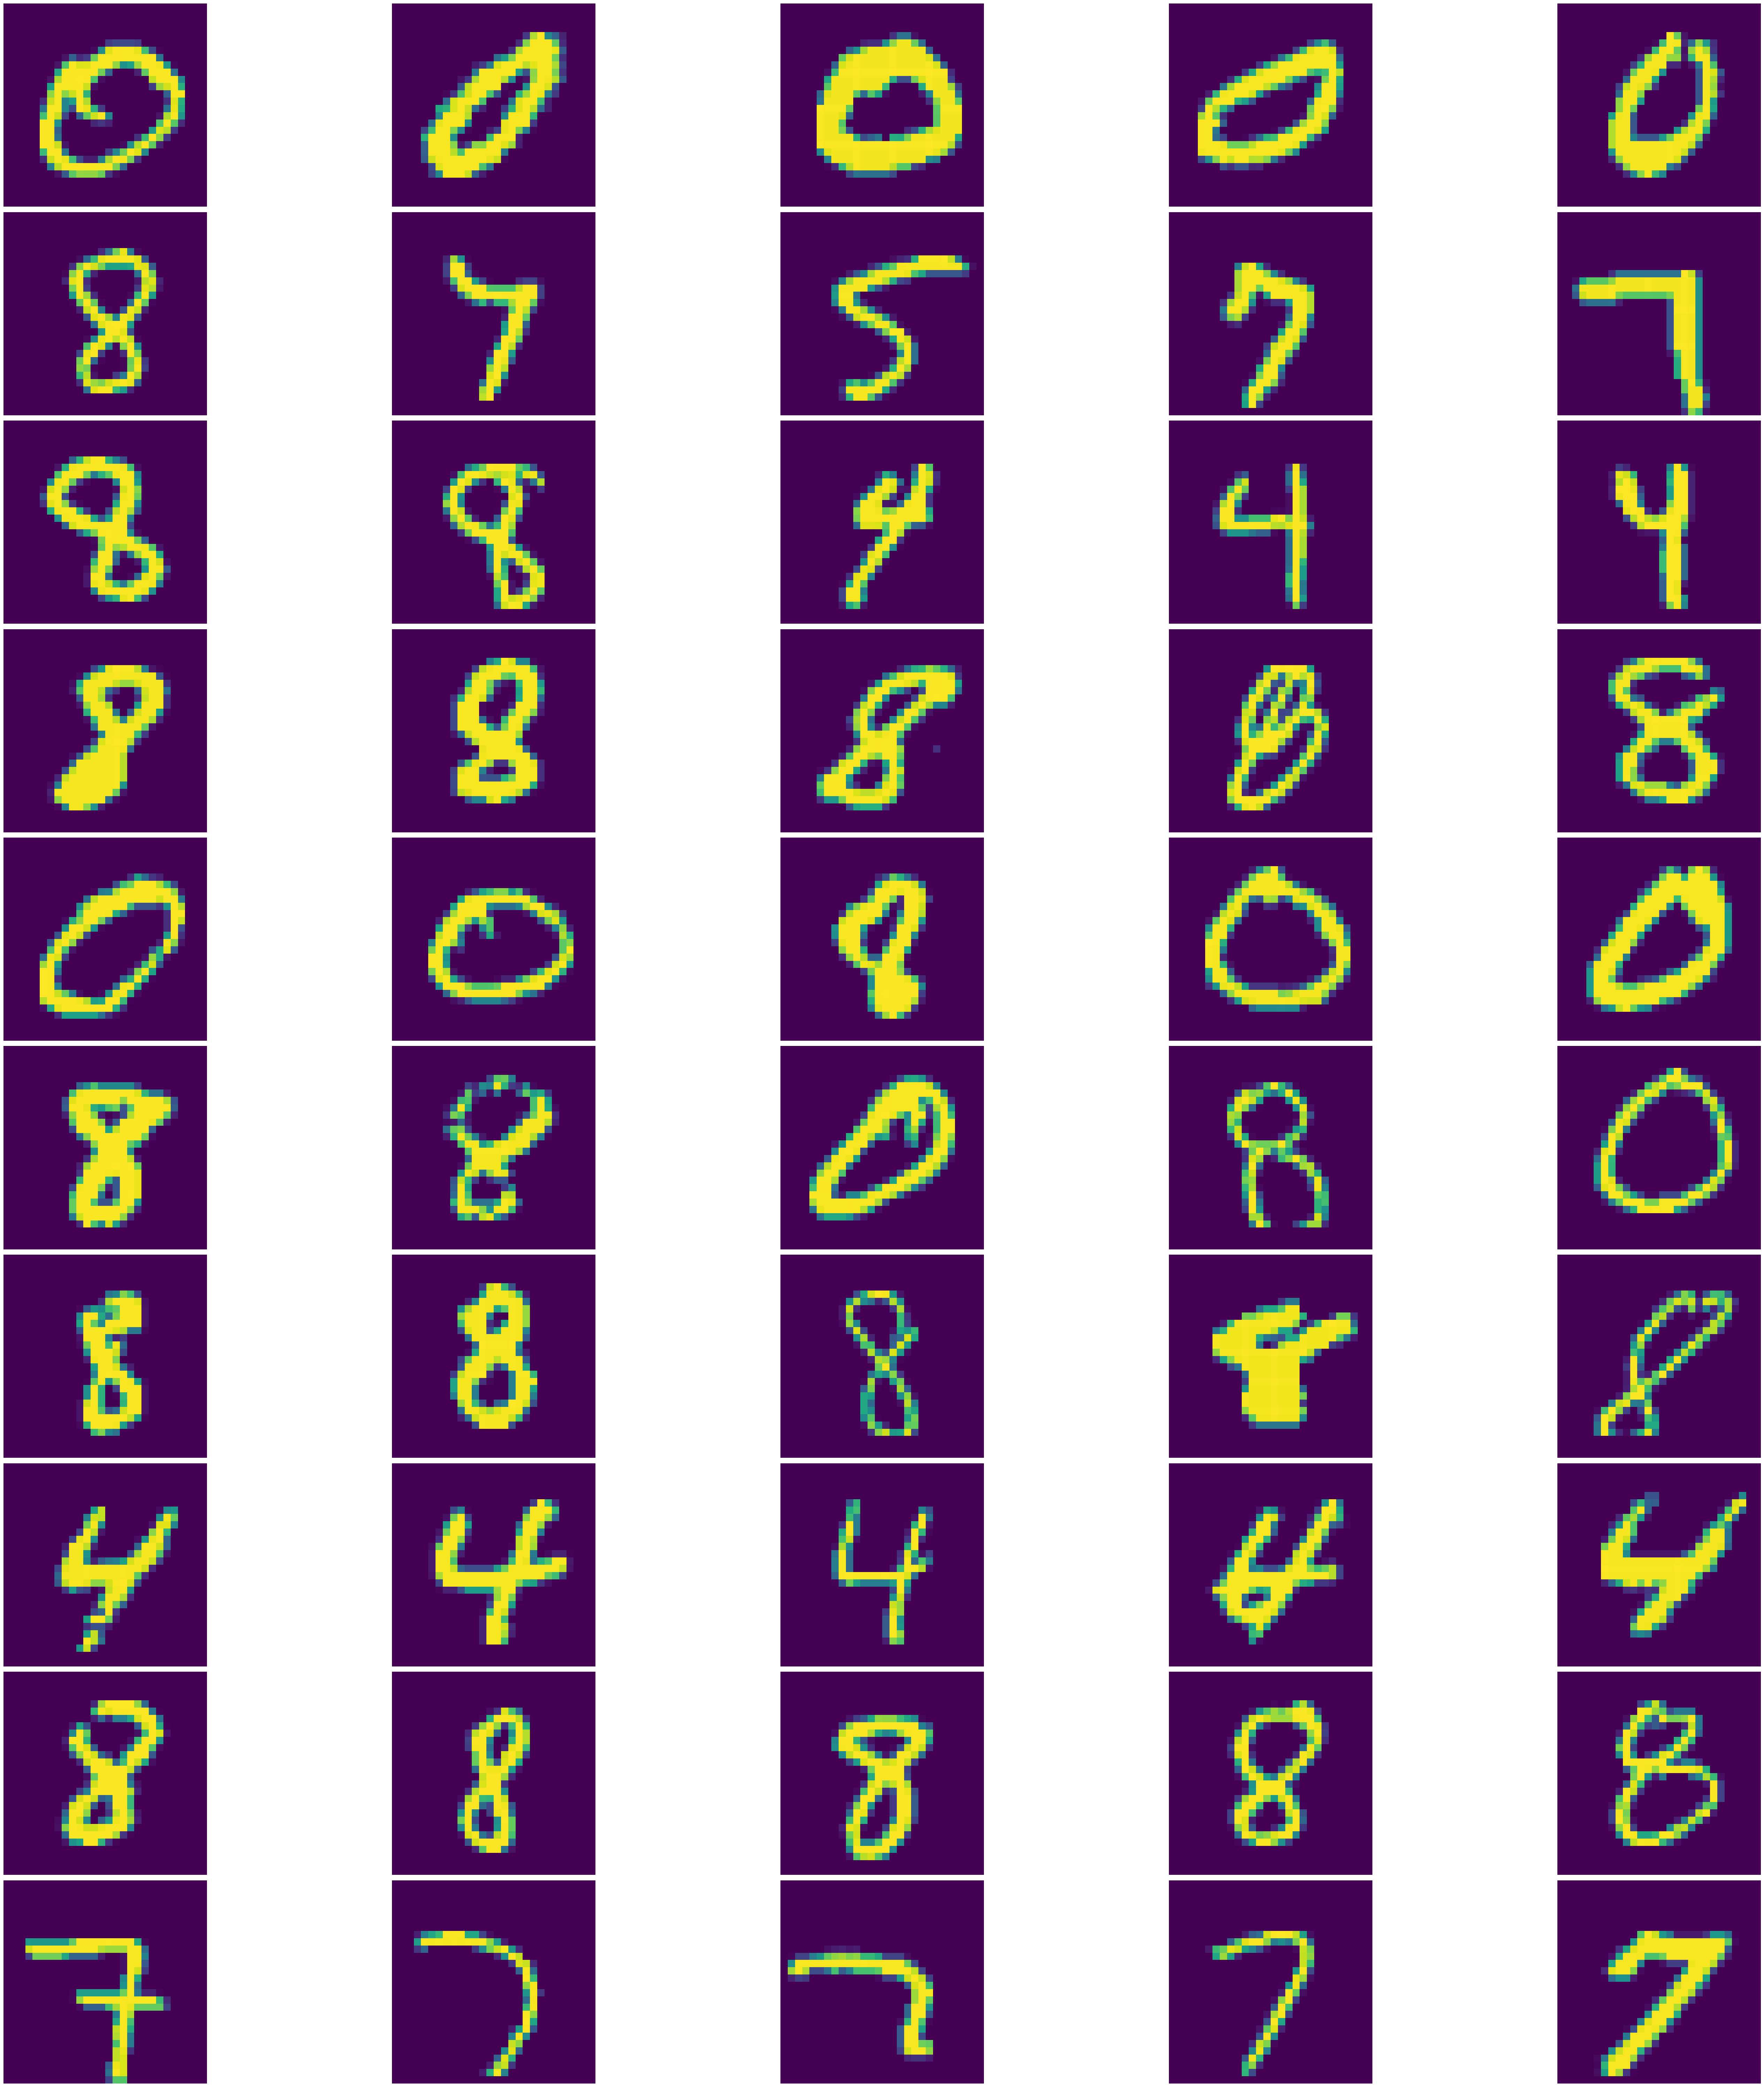

In [8]:
import random

plt.figure(figsize=(60, 60))
for i in range(len(user_groups)):
    for j in range(5):
        mx = random.randint(1, 100)
        image, label = train_dataset[int(user_groups[i][mx])]
        ax = plt.subplot(10, 5, i*5+j+1)
        ax.imshow(image[0])
        ax.axis('off')

plt.tight_layout()
plt.show()


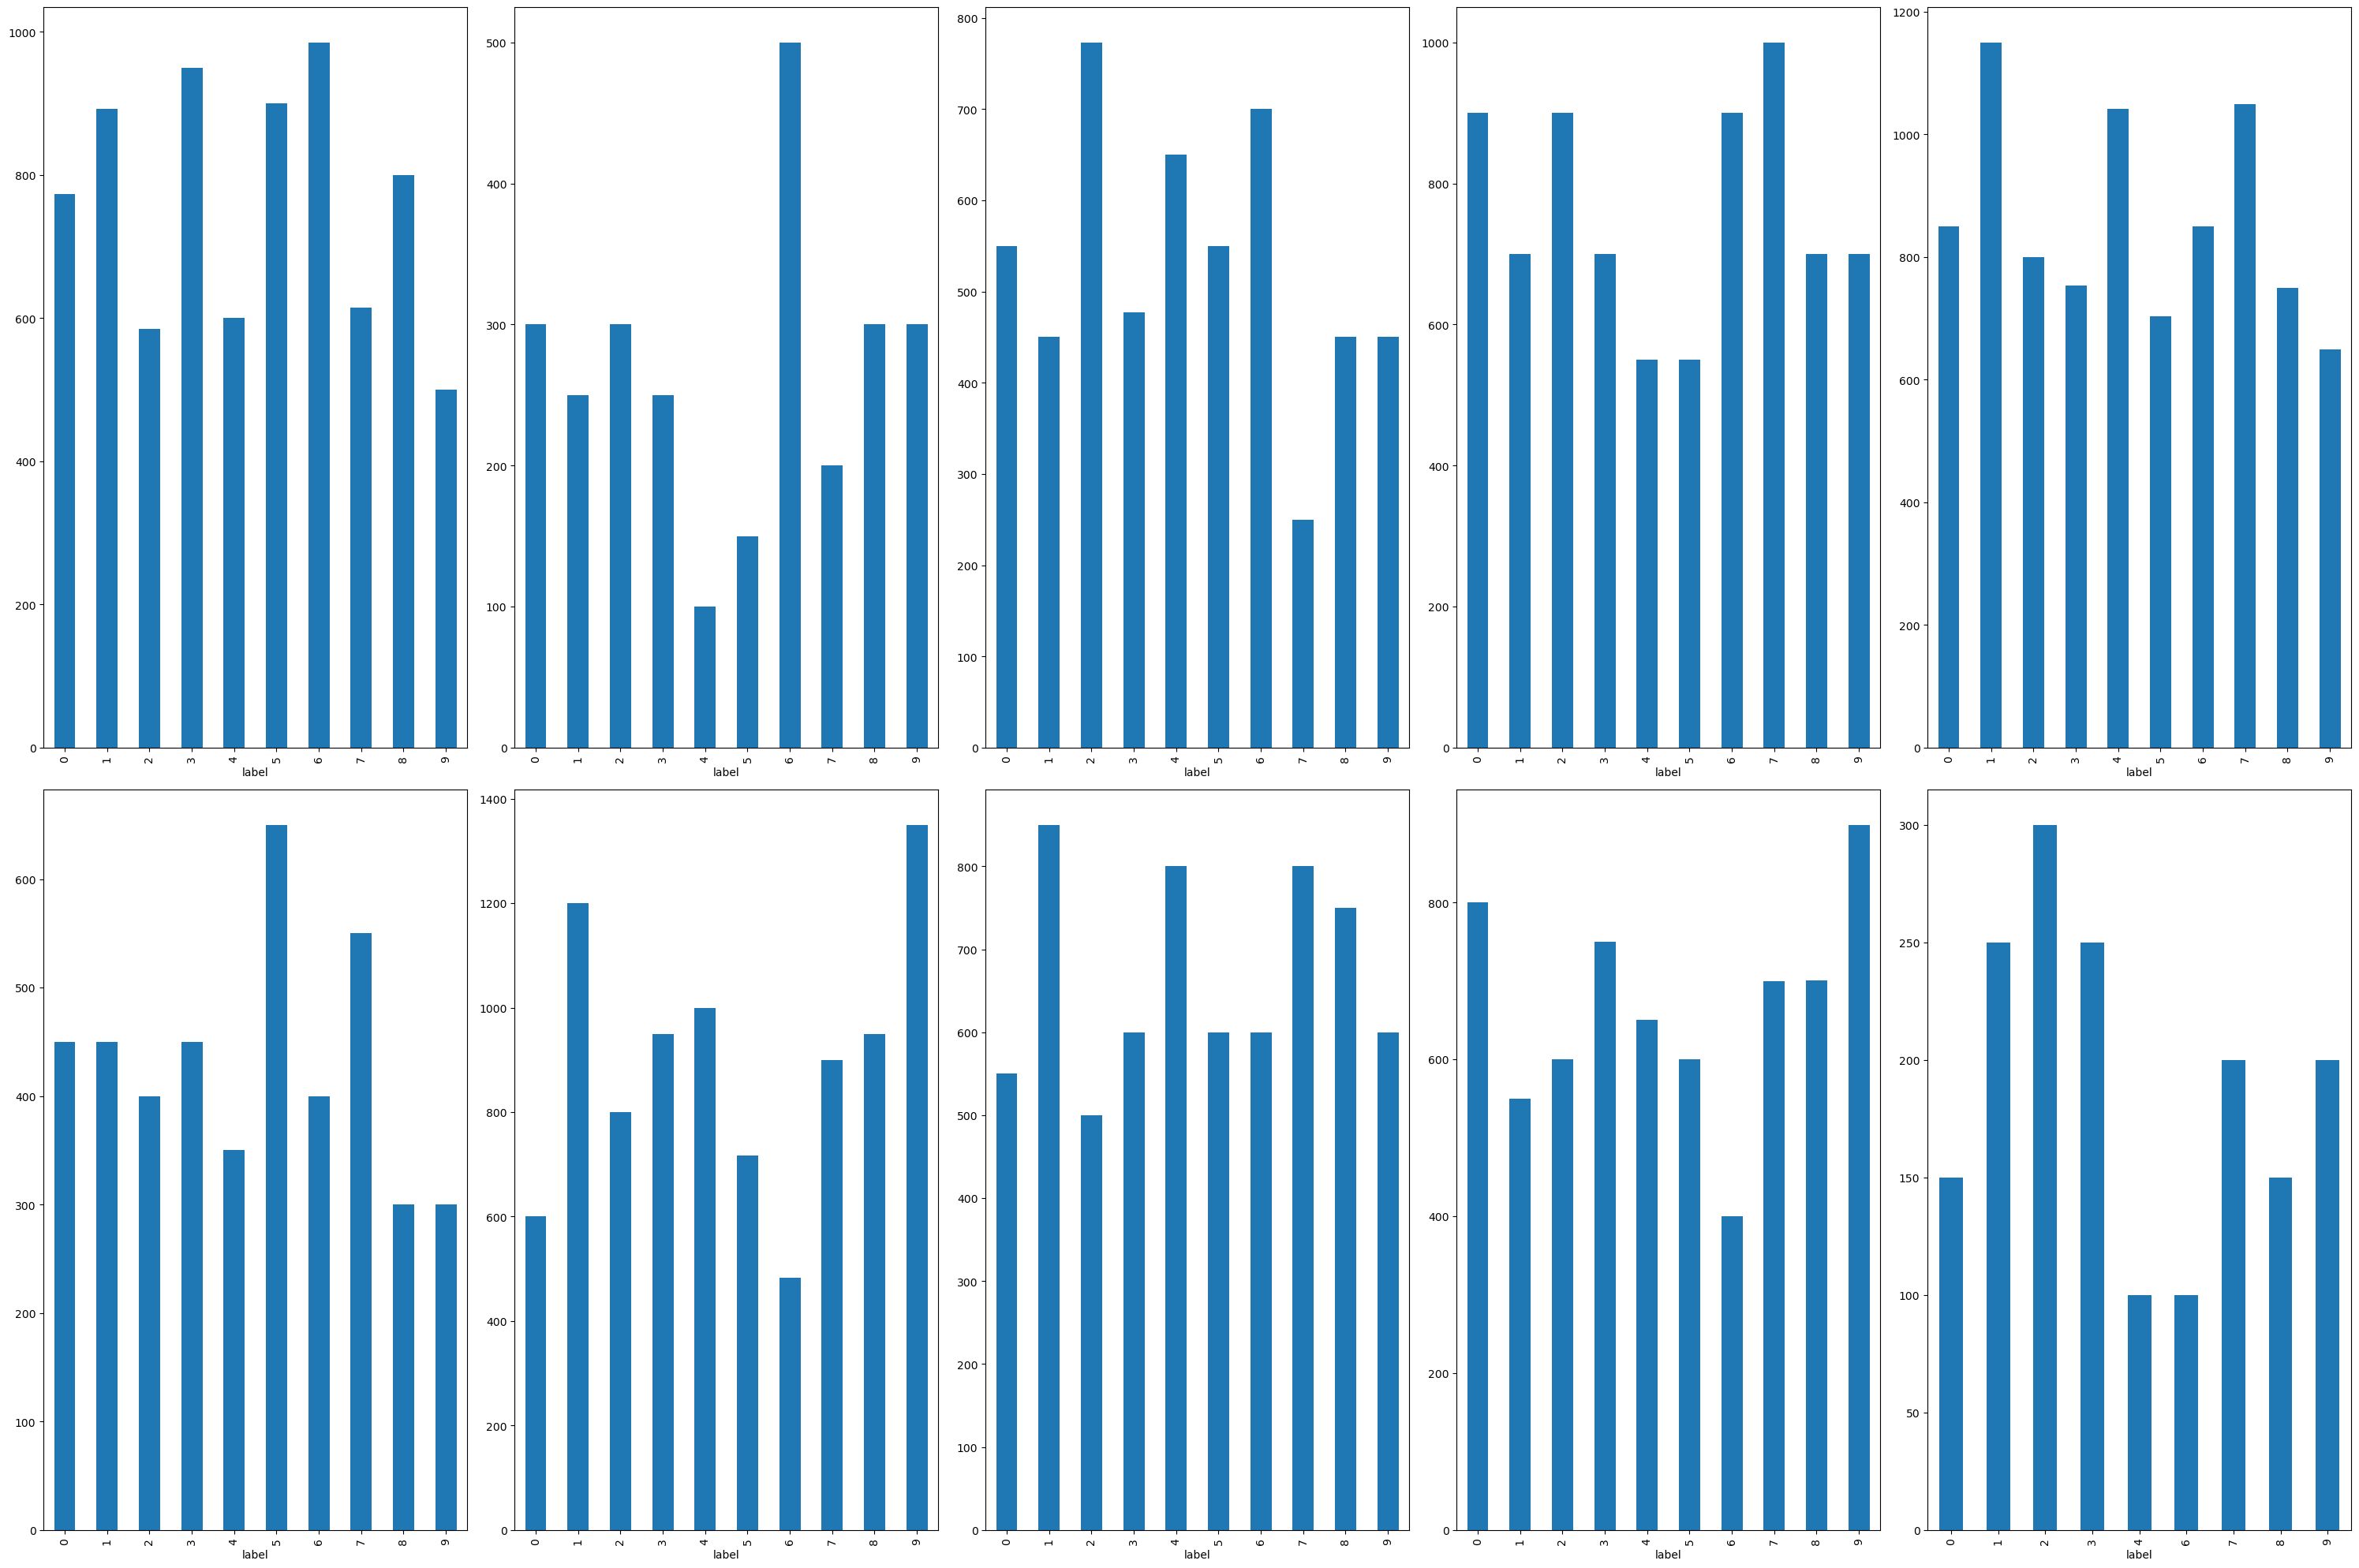

In [10]:
plt.figure(figsize=(30, 20))
for i in range(len(user_groups)):
    users = user_groups[i]
    labels = [train_dataset[int(i)][1] for i in users]
    user0_data = {'index': user_groups[i], 'label': labels}
    user0_df = pd.DataFrame(user0_data)
    ax = plt.subplot(2, 5, i+1)
    user0_df.label.value_counts().sort_index().plot(kind='bar', ax=ax)
    

plt.tight_layout()
plt.show()

In [11]:
class MLP(nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out):
        super(MLP, self).__init__()
        self.layer_input = nn.Linear(dim_in, dim_hidden)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.layer_hidden1 = nn.Linear(dim_hidden, dim_hidden)
        self.layer_hidden2 = nn.Linear(dim_hidden, dim_out)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, x.shape[1]*x.shape[-2]*x.shape[-1])
        x = self.layer_input(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_hidden1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer_hidden2(x)
        return self.softmax(x)

class CNNMNist(nn.Module):
    def __init__(self, args):
        super(CNNMNist, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(64* 7* 7, 512)
        self.fc2 = nn.Linear(512, args.num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [12]:
# import pytorch_model_summary as ptsm
print(MLP(784,200,10))
# print(ptsm.summary(MLP(784, 200, 10), torch.rand((1, 1, 28, 28)), show_input=True))
# print(ptsm.summary(CNNMNist(args=args), torch.rand((1, 1, 28, 28)), show_input=True))

MLP(
  (layer_input): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_hidden1): Linear(in_features=200, out_features=200, bias=True)
  (layer_hidden2): Linear(in_features=200, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


## DataLoader, DataSplit, LocalUpdate

In [13]:
from torch.utils.data import Dataset, DataLoader
class DataSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]
        

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, index):
        image, label = self.dataset[self.idxs[index]]
        return torch.tensor(image), torch.tensor(label)

class LocalUpdate(object):
    def __init__(self, args, dataset, idx):
        self.args = args
        self.trainLoader, self.validLoader, self.testLoader = self.train_valid_test(self, dataset, idx)
        self.device = 'cuda' if args.gpu else 'cpu'

    def train_valid_test(self, dataset, idx):
        idxs_train = idx[:int(0.8*len(idx))]
        idxs_valid = idx[int(0.8*len(idx)):int(0.9*len(idx))]
        idxs_test = idx[int(0.9*len(idx)):]

        trainLoader = DataLoader(DataSplit(dataset, idxs_train), batch_size=self.args.local_bs,
                                 shuffle=True)
        validLoader = DataLoader(DataSplit(dataset, idxs_valid), batch_size=self.args.local_bs,
                                 shuffle=True)
        testLoader = DataLoader(DataSplit(dataset, idxs_test), batch_size=self.args.local_bs,
                                 shuffle=True)
        
        return trainLoader, validLoader, testLoader
        
        
        


In [ ]:
from tqdm import tqdm
global_model = MLP(784, 200, 10)
global_model.train()
global_weights = global_model.state_dict()

for epoch in tqdm(range(50)):


100%|██████████| 50/50 [00:00<00:00, 25951.64it/s]
